# Final Project - NLP Project
### Course: `PROG8245- Machine Learning Programming`
### Team - Members:
- **Yun-Chen Wang**     - Student number: 9040873
- **Tai Siang Huang**   - Student number: 9006413
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install required libraries
!pip install -q transformers tqdm
!pip install -q nltk emoji
!pip install -q sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.4 MB/s eta 0:00:00


In [ ]:
# Check if GPU is available
import torch
print("Using GPU" if torch.cuda.is_available() else "Using CPU")

Using GPU


In [ ]:
import os
import gc
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import joblib
from scipy import sparse
from sentence_transformers import SentenceTransformer

import re
import nltk
import emoji
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import pipeline


# Download NLTK resources
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## 1. Data Collection

### About the dataset - 'Sentiment140'

The Sentiment140 dataset contains 1,600,000 tweets collected via the Twitter API. Each tweet is labeled with sentiment: 0 for negative and 4 for positive, making the dataset suitable for sentiment analysis tasks.

### Load dataset

In [ ]:
path = "/content/drive/MyDrive/NLP_Proj/training.1600000.processed.noemoticon.csv"
raw_df = pd.read_csv(path, encoding='latin-1',  names=['target','ids','date','flag','user','text'])
print(f"Load dataframe from {path}, Shape: {raw_df.shape}")
pd.set_option('display.max_colwidth', None)
display(raw_df.head()) # print the first 5 rows of the dataset


Load dataframe from /content/drive/MyDrive/NLP_Proj/training.1600000.processed.noemoticon.csv, Shape: (1600000, 6)


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


## Annotation: two methods
- by target columns in the original dataset
- by huggingface pretrained model 'transformer "sentiment-analysis"'

### Method 1 - annotate by target

In [ ]:
# Define label mapping from target column
label_map = {0: 'negative', 2: 'neutral', 4: 'positive'}

# Create a new DataFrame that includes text and mapped sentiment labels
df_method1 = raw_df[['text']].copy()  # Keep only text for now
df_method1['sentiment_label_method1'] = raw_df['target'].map(label_map)

# Display preview
df_method1.head()

,text,sentiment_label_method1
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",negative
1,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,negative
2,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,negative
3,my whole body feels itchy and like its on fire,negative
4,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",negative


### Method 2 - annotate by target by transformer "sentiment-analysis"
- Model: distilbert-base-uncased-finetuned-sst-2-english


In [ ]:
# Load a pre-trained model for 3-class sentiment classification
classifier = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment",
    device=0  # Use GPU (device 0)
)

# Mapping of model labels to sentiment classes
label_map = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

# Enable tqdm progress bar for pandas apply
tqdm.pandas()

# Function to get sentiment label from model
def predict_sentiment(text):
  result = classifier(text, truncation=True, max_length=512)[0] # Truncate input to 512 tokens
  return label_map[result['label']]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
def clear_buffer(_var):
  # Delete the classifier pipeline object
  del _var

  # Force Python to release unused memory
  gc.collect()

  # Clear GPU memory cache
  torch.cuda.empty_cache()
  return


### Store the annotation results into df_method2

In [ ]:
# Set batch size and calculate total number of rows
batch_size = 1000
total = len(raw_df)

output_folder = "/content/drive/MyDrive/NLP_Proj/Output/"
os.makedirs(output_folder, exist_ok=True)

# Loop over the dataset in batches
for start in range(0, total, batch_size):
    end = min(start + batch_size, total)
    print(f"Processing rows {start} to {end - 1}")
    filename = f"{output_folder}method2_annotation_{start:06d}_to_{end-1:06d}.csv"
    if os.path.exists(filename):
        print(f"\t>>>File already exists: {filename}, skipping...")
        continue

    # Select only the 'text' column for this batch
    df_method2 = raw_df[['text']].iloc[start:end].copy()

    # Apply the sentiment analysis model to each row
    df_method2['sentiment_label_method2'] = df_method2['text'].progress_apply(predict_sentiment)

    # Save the batch to a CSV file with a clear filename
    # filename = f"{output_folder}method2_annotation_{start:06d}_to_{end-1:06d}.csv"
    df_method2.to_csv(filename, index=False)
    print(f"Saved to {filename}")


Processing rows 0 to 999
	>>>File already exists: /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_000000_to_000999.csv, skipping...
Processing rows 1000 to 1999
	>>>File already exists: /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_001000_to_001999.csv, skipping...
Processing rows 2000 to 2999
	>>>File already exists: /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_002000_to_002999.csv, skipping...
Processing rows 3000 to 3999
	>>>File already exists: /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_003000_to_003999.csv, skipping...
Processing rows 4000 to 4999
	>>>File already exists: /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_004000_to_004999.csv, skipping...
Processing rows 5000 to 5999
	>>>File already exists: /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_005000_to_005999.csv, skipping...
Processing rows 6000 to 6999
	>>>File already exists: /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_006000_to_006999

100%|██████████| 1000/1000 [02:57<00:00,  5.63it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1317000_to_1317999.csv
Processing rows 1318000 to 1318999


100%|██████████| 1000/1000 [02:13<00:00,  7.51it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1318000_to_1318999.csv
Processing rows 1319000 to 1319999


100%|██████████| 1000/1000 [02:10<00:00,  7.66it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1319000_to_1319999.csv
Processing rows 1320000 to 1320999


100%|██████████| 1000/1000 [02:11<00:00,  7.60it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1320000_to_1320999.csv
Processing rows 1321000 to 1321999


100%|██████████| 1000/1000 [02:10<00:00,  7.68it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1321000_to_1321999.csv
Processing rows 1322000 to 1322999


100%|██████████| 1000/1000 [02:09<00:00,  7.74it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1322000_to_1322999.csv
Processing rows 1323000 to 1323999


100%|██████████| 1000/1000 [02:08<00:00,  7.80it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1323000_to_1323999.csv
Processing rows 1324000 to 1324999


100%|██████████| 1000/1000 [02:07<00:00,  7.83it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1324000_to_1324999.csv
Processing rows 1325000 to 1325999


100%|██████████| 1000/1000 [02:08<00:00,  7.77it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1325000_to_1325999.csv
Processing rows 1326000 to 1326999


100%|██████████| 1000/1000 [02:06<00:00,  7.88it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1326000_to_1326999.csv
Processing rows 1327000 to 1327999


100%|██████████| 1000/1000 [02:07<00:00,  7.85it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1327000_to_1327999.csv
Processing rows 1328000 to 1328999


100%|██████████| 1000/1000 [02:08<00:00,  7.77it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1328000_to_1328999.csv
Processing rows 1329000 to 1329999


100%|██████████| 1000/1000 [02:09<00:00,  7.75it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1329000_to_1329999.csv
Processing rows 1330000 to 1330999


100%|██████████| 1000/1000 [02:08<00:00,  7.79it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1330000_to_1330999.csv
Processing rows 1331000 to 1331999


100%|██████████| 1000/1000 [02:13<00:00,  7.52it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1331000_to_1331999.csv
Processing rows 1332000 to 1332999


100%|██████████| 1000/1000 [02:11<00:00,  7.62it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1332000_to_1332999.csv
Processing rows 1333000 to 1333999


100%|██████████| 1000/1000 [02:10<00:00,  7.64it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1333000_to_1333999.csv
Processing rows 1334000 to 1334999


100%|██████████| 1000/1000 [02:11<00:00,  7.61it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1334000_to_1334999.csv
Processing rows 1335000 to 1335999


100%|██████████| 1000/1000 [02:08<00:00,  7.76it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1335000_to_1335999.csv
Processing rows 1336000 to 1336999


100%|██████████| 1000/1000 [02:10<00:00,  7.64it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1336000_to_1336999.csv
Processing rows 1337000 to 1337999


100%|██████████| 1000/1000 [02:07<00:00,  7.81it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1337000_to_1337999.csv
Processing rows 1338000 to 1338999


100%|██████████| 1000/1000 [02:06<00:00,  7.93it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1338000_to_1338999.csv
Processing rows 1339000 to 1339999


100%|██████████| 1000/1000 [02:08<00:00,  7.81it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1339000_to_1339999.csv
Processing rows 1340000 to 1340999


100%|██████████| 1000/1000 [02:08<00:00,  7.75it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1340000_to_1340999.csv
Processing rows 1341000 to 1341999


100%|██████████| 1000/1000 [02:08<00:00,  7.78it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1341000_to_1341999.csv
Processing rows 1342000 to 1342999


100%|██████████| 1000/1000 [02:10<00:00,  7.66it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1342000_to_1342999.csv
Processing rows 1343000 to 1343999


100%|██████████| 1000/1000 [02:08<00:00,  7.78it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1343000_to_1343999.csv
Processing rows 1344000 to 1344999


100%|██████████| 1000/1000 [02:11<00:00,  7.59it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1344000_to_1344999.csv
Processing rows 1345000 to 1345999


100%|██████████| 1000/1000 [02:10<00:00,  7.68it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1345000_to_1345999.csv
Processing rows 1346000 to 1346999


100%|██████████| 1000/1000 [02:09<00:00,  7.72it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1346000_to_1346999.csv
Processing rows 1347000 to 1347999


100%|██████████| 1000/1000 [02:08<00:00,  7.78it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1347000_to_1347999.csv
Processing rows 1348000 to 1348999


100%|██████████| 1000/1000 [02:10<00:00,  7.67it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1348000_to_1348999.csv
Processing rows 1349000 to 1349999


100%|██████████| 1000/1000 [02:08<00:00,  7.76it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1349000_to_1349999.csv
Processing rows 1350000 to 1350999


100%|██████████| 1000/1000 [02:11<00:00,  7.61it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1350000_to_1350999.csv
Processing rows 1351000 to 1351999


100%|██████████| 1000/1000 [02:04<00:00,  8.02it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1351000_to_1351999.csv
Processing rows 1352000 to 1352999


100%|██████████| 1000/1000 [02:07<00:00,  7.84it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1352000_to_1352999.csv
Processing rows 1353000 to 1353999


100%|██████████| 1000/1000 [02:08<00:00,  7.77it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1353000_to_1353999.csv
Processing rows 1354000 to 1354999


100%|██████████| 1000/1000 [02:08<00:00,  7.79it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1354000_to_1354999.csv
Processing rows 1355000 to 1355999


100%|██████████| 1000/1000 [02:07<00:00,  7.84it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1355000_to_1355999.csv
Processing rows 1356000 to 1356999


100%|██████████| 1000/1000 [02:08<00:00,  7.77it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1356000_to_1356999.csv
Processing rows 1357000 to 1357999


100%|██████████| 1000/1000 [02:08<00:00,  7.80it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1357000_to_1357999.csv
Processing rows 1358000 to 1358999


100%|██████████| 1000/1000 [02:15<00:00,  7.38it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1358000_to_1358999.csv
Processing rows 1359000 to 1359999


100%|██████████| 1000/1000 [02:07<00:00,  7.82it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1359000_to_1359999.csv
Processing rows 1360000 to 1360999


100%|██████████| 1000/1000 [02:11<00:00,  7.63it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1360000_to_1360999.csv
Processing rows 1361000 to 1361999


100%|██████████| 1000/1000 [02:10<00:00,  7.68it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1361000_to_1361999.csv
Processing rows 1362000 to 1362999


100%|██████████| 1000/1000 [02:11<00:00,  7.58it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1362000_to_1362999.csv
Processing rows 1363000 to 1363999


100%|██████████| 1000/1000 [02:13<00:00,  7.48it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1363000_to_1363999.csv
Processing rows 1364000 to 1364999


100%|██████████| 1000/1000 [02:10<00:00,  7.66it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1364000_to_1364999.csv
Processing rows 1365000 to 1365999


100%|██████████| 1000/1000 [02:08<00:00,  7.75it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1365000_to_1365999.csv
Processing rows 1366000 to 1366999


100%|██████████| 1000/1000 [02:10<00:00,  7.65it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1366000_to_1366999.csv
Processing rows 1367000 to 1367999


100%|██████████| 1000/1000 [02:12<00:00,  7.53it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1367000_to_1367999.csv
Processing rows 1368000 to 1368999


100%|██████████| 1000/1000 [02:12<00:00,  7.52it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1368000_to_1368999.csv
Processing rows 1369000 to 1369999


100%|██████████| 1000/1000 [02:13<00:00,  7.50it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1369000_to_1369999.csv
Processing rows 1370000 to 1370999


100%|██████████| 1000/1000 [02:11<00:00,  7.62it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1370000_to_1370999.csv
Processing rows 1371000 to 1371999


100%|██████████| 1000/1000 [02:10<00:00,  7.68it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1371000_to_1371999.csv
Processing rows 1372000 to 1372999


100%|██████████| 1000/1000 [02:11<00:00,  7.61it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1372000_to_1372999.csv
Processing rows 1373000 to 1373999


100%|██████████| 1000/1000 [02:10<00:00,  7.64it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1373000_to_1373999.csv
Processing rows 1374000 to 1374999


100%|██████████| 1000/1000 [02:08<00:00,  7.78it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1374000_to_1374999.csv
Processing rows 1375000 to 1375999


100%|██████████| 1000/1000 [02:09<00:00,  7.71it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1375000_to_1375999.csv
Processing rows 1376000 to 1376999


100%|██████████| 1000/1000 [02:11<00:00,  7.62it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1376000_to_1376999.csv
Processing rows 1377000 to 1377999


100%|██████████| 1000/1000 [02:18<00:00,  7.24it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1377000_to_1377999.csv
Processing rows 1378000 to 1378999


100%|██████████| 1000/1000 [02:13<00:00,  7.47it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1378000_to_1378999.csv
Processing rows 1379000 to 1379999


100%|██████████| 1000/1000 [02:15<00:00,  7.38it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1379000_to_1379999.csv
Processing rows 1380000 to 1380999


100%|██████████| 1000/1000 [02:14<00:00,  7.45it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1380000_to_1380999.csv
Processing rows 1381000 to 1381999


100%|██████████| 1000/1000 [02:14<00:00,  7.43it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1381000_to_1381999.csv
Processing rows 1382000 to 1382999


100%|██████████| 1000/1000 [02:15<00:00,  7.38it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1382000_to_1382999.csv
Processing rows 1383000 to 1383999


100%|██████████| 1000/1000 [02:12<00:00,  7.55it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1383000_to_1383999.csv
Processing rows 1384000 to 1384999


100%|██████████| 1000/1000 [02:12<00:00,  7.54it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1384000_to_1384999.csv
Processing rows 1385000 to 1385999


100%|██████████| 1000/1000 [02:09<00:00,  7.73it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1385000_to_1385999.csv
Processing rows 1386000 to 1386999


100%|██████████| 1000/1000 [02:16<00:00,  7.34it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1386000_to_1386999.csv
Processing rows 1387000 to 1387999


100%|██████████| 1000/1000 [02:16<00:00,  7.32it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1387000_to_1387999.csv
Processing rows 1388000 to 1388999


100%|██████████| 1000/1000 [02:18<00:00,  7.23it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1388000_to_1388999.csv
Processing rows 1389000 to 1389999


100%|██████████| 1000/1000 [02:12<00:00,  7.54it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1389000_to_1389999.csv
Processing rows 1390000 to 1390999


100%|██████████| 1000/1000 [02:15<00:00,  7.38it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1390000_to_1390999.csv
Processing rows 1391000 to 1391999


100%|██████████| 1000/1000 [02:11<00:00,  7.62it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1391000_to_1391999.csv
Processing rows 1392000 to 1392999


100%|██████████| 1000/1000 [02:12<00:00,  7.55it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1392000_to_1392999.csv
Processing rows 1393000 to 1393999


100%|██████████| 1000/1000 [02:15<00:00,  7.40it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1393000_to_1393999.csv
Processing rows 1394000 to 1394999


100%|██████████| 1000/1000 [02:10<00:00,  7.64it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1394000_to_1394999.csv
Processing rows 1395000 to 1395999


100%|██████████| 1000/1000 [02:13<00:00,  7.47it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1395000_to_1395999.csv
Processing rows 1396000 to 1396999


100%|██████████| 1000/1000 [02:11<00:00,  7.59it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1396000_to_1396999.csv
Processing rows 1397000 to 1397999


100%|██████████| 1000/1000 [02:13<00:00,  7.47it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1397000_to_1397999.csv
Processing rows 1398000 to 1398999


100%|██████████| 1000/1000 [02:11<00:00,  7.61it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1398000_to_1398999.csv
Processing rows 1399000 to 1399999


100%|██████████| 1000/1000 [02:11<00:00,  7.62it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1399000_to_1399999.csv
Processing rows 1400000 to 1400999


100%|██████████| 1000/1000 [02:12<00:00,  7.53it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1400000_to_1400999.csv
Processing rows 1401000 to 1401999


100%|██████████| 1000/1000 [02:10<00:00,  7.66it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1401000_to_1401999.csv
Processing rows 1402000 to 1402999


100%|██████████| 1000/1000 [02:12<00:00,  7.56it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1402000_to_1402999.csv
Processing rows 1403000 to 1403999


100%|██████████| 1000/1000 [02:10<00:00,  7.64it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1403000_to_1403999.csv
Processing rows 1404000 to 1404999


100%|██████████| 1000/1000 [02:15<00:00,  7.39it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1404000_to_1404999.csv
Processing rows 1405000 to 1405999


100%|██████████| 1000/1000 [02:14<00:00,  7.45it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1405000_to_1405999.csv
Processing rows 1406000 to 1406999


100%|██████████| 1000/1000 [02:13<00:00,  7.47it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1406000_to_1406999.csv
Processing rows 1407000 to 1407999


100%|██████████| 1000/1000 [02:11<00:00,  7.63it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1407000_to_1407999.csv
Processing rows 1408000 to 1408999


100%|██████████| 1000/1000 [02:10<00:00,  7.64it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1408000_to_1408999.csv
Processing rows 1409000 to 1409999


100%|██████████| 1000/1000 [02:09<00:00,  7.71it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1409000_to_1409999.csv
Processing rows 1410000 to 1410999


100%|██████████| 1000/1000 [02:12<00:00,  7.54it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1410000_to_1410999.csv
Processing rows 1411000 to 1411999


100%|██████████| 1000/1000 [02:10<00:00,  7.68it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1411000_to_1411999.csv
Processing rows 1412000 to 1412999


100%|██████████| 1000/1000 [02:12<00:00,  7.56it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1412000_to_1412999.csv
Processing rows 1413000 to 1413999


100%|██████████| 1000/1000 [02:11<00:00,  7.61it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1413000_to_1413999.csv
Processing rows 1414000 to 1414999


100%|██████████| 1000/1000 [02:13<00:00,  7.49it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1414000_to_1414999.csv
Processing rows 1415000 to 1415999


100%|██████████| 1000/1000 [02:17<00:00,  7.29it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1415000_to_1415999.csv
Processing rows 1416000 to 1416999


100%|██████████| 1000/1000 [02:15<00:00,  7.37it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1416000_to_1416999.csv
Processing rows 1417000 to 1417999


100%|██████████| 1000/1000 [02:15<00:00,  7.40it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1417000_to_1417999.csv
Processing rows 1418000 to 1418999


100%|██████████| 1000/1000 [02:11<00:00,  7.59it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1418000_to_1418999.csv
Processing rows 1419000 to 1419999


100%|██████████| 1000/1000 [02:12<00:00,  7.52it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1419000_to_1419999.csv
Processing rows 1420000 to 1420999


100%|██████████| 1000/1000 [02:13<00:00,  7.50it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1420000_to_1420999.csv
Processing rows 1421000 to 1421999


100%|██████████| 1000/1000 [02:13<00:00,  7.47it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1421000_to_1421999.csv
Processing rows 1422000 to 1422999


100%|██████████| 1000/1000 [02:15<00:00,  7.40it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1422000_to_1422999.csv
Processing rows 1423000 to 1423999


100%|██████████| 1000/1000 [02:09<00:00,  7.74it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1423000_to_1423999.csv
Processing rows 1424000 to 1424999


100%|██████████| 1000/1000 [02:08<00:00,  7.79it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1424000_to_1424999.csv
Processing rows 1425000 to 1425999


100%|██████████| 1000/1000 [02:11<00:00,  7.58it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1425000_to_1425999.csv
Processing rows 1426000 to 1426999


100%|██████████| 1000/1000 [02:12<00:00,  7.56it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1426000_to_1426999.csv
Processing rows 1427000 to 1427999


100%|██████████| 1000/1000 [02:13<00:00,  7.52it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1427000_to_1427999.csv
Processing rows 1428000 to 1428999


100%|██████████| 1000/1000 [02:09<00:00,  7.73it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1428000_to_1428999.csv
Processing rows 1429000 to 1429999


100%|██████████| 1000/1000 [02:12<00:00,  7.56it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1429000_to_1429999.csv
Processing rows 1430000 to 1430999


100%|██████████| 1000/1000 [02:10<00:00,  7.65it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1430000_to_1430999.csv
Processing rows 1431000 to 1431999


100%|██████████| 1000/1000 [02:10<00:00,  7.68it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1431000_to_1431999.csv
Processing rows 1432000 to 1432999


100%|██████████| 1000/1000 [02:07<00:00,  7.84it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1432000_to_1432999.csv
Processing rows 1433000 to 1433999


100%|██████████| 1000/1000 [02:08<00:00,  7.75it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1433000_to_1433999.csv
Processing rows 1434000 to 1434999


100%|██████████| 1000/1000 [02:10<00:00,  7.68it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1434000_to_1434999.csv
Processing rows 1435000 to 1435999


100%|██████████| 1000/1000 [02:08<00:00,  7.76it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1435000_to_1435999.csv
Processing rows 1436000 to 1436999


100%|██████████| 1000/1000 [02:11<00:00,  7.62it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1436000_to_1436999.csv
Processing rows 1437000 to 1437999


100%|██████████| 1000/1000 [02:08<00:00,  7.78it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1437000_to_1437999.csv
Processing rows 1438000 to 1438999


100%|██████████| 1000/1000 [02:10<00:00,  7.69it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1438000_to_1438999.csv
Processing rows 1439000 to 1439999


100%|██████████| 1000/1000 [02:09<00:00,  7.75it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1439000_to_1439999.csv
Processing rows 1440000 to 1440999


100%|██████████| 1000/1000 [02:14<00:00,  7.43it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1440000_to_1440999.csv
Processing rows 1441000 to 1441999


100%|██████████| 1000/1000 [02:11<00:00,  7.60it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1441000_to_1441999.csv
Processing rows 1442000 to 1442999


100%|██████████| 1000/1000 [02:11<00:00,  7.59it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1442000_to_1442999.csv
Processing rows 1443000 to 1443999


100%|██████████| 1000/1000 [02:09<00:00,  7.74it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1443000_to_1443999.csv
Processing rows 1444000 to 1444999


100%|██████████| 1000/1000 [02:09<00:00,  7.73it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1444000_to_1444999.csv
Processing rows 1445000 to 1445999


100%|██████████| 1000/1000 [02:08<00:00,  7.79it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1445000_to_1445999.csv
Processing rows 1446000 to 1446999


100%|██████████| 1000/1000 [02:09<00:00,  7.70it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1446000_to_1446999.csv
Processing rows 1447000 to 1447999


100%|██████████| 1000/1000 [02:08<00:00,  7.77it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1447000_to_1447999.csv
Processing rows 1448000 to 1448999


100%|██████████| 1000/1000 [02:14<00:00,  7.43it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1448000_to_1448999.csv
Processing rows 1449000 to 1449999


100%|██████████| 1000/1000 [02:09<00:00,  7.70it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1449000_to_1449999.csv
Processing rows 1450000 to 1450999


100%|██████████| 1000/1000 [02:15<00:00,  7.36it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1450000_to_1450999.csv
Processing rows 1451000 to 1451999


100%|██████████| 1000/1000 [02:15<00:00,  7.37it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1451000_to_1451999.csv
Processing rows 1452000 to 1452999


100%|██████████| 1000/1000 [02:12<00:00,  7.52it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1452000_to_1452999.csv
Processing rows 1453000 to 1453999


100%|██████████| 1000/1000 [02:10<00:00,  7.68it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1453000_to_1453999.csv
Processing rows 1454000 to 1454999


100%|██████████| 1000/1000 [02:07<00:00,  7.81it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1454000_to_1454999.csv
Processing rows 1455000 to 1455999


100%|██████████| 1000/1000 [02:09<00:00,  7.69it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1455000_to_1455999.csv
Processing rows 1456000 to 1456999


100%|██████████| 1000/1000 [02:07<00:00,  7.87it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1456000_to_1456999.csv
Processing rows 1457000 to 1457999


100%|██████████| 1000/1000 [02:11<00:00,  7.61it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1457000_to_1457999.csv
Processing rows 1458000 to 1458999


100%|██████████| 1000/1000 [02:08<00:00,  7.76it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1458000_to_1458999.csv
Processing rows 1459000 to 1459999


100%|██████████| 1000/1000 [02:12<00:00,  7.54it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1459000_to_1459999.csv
Processing rows 1460000 to 1460999


100%|██████████| 1000/1000 [02:08<00:00,  7.77it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1460000_to_1460999.csv
Processing rows 1461000 to 1461999


100%|██████████| 1000/1000 [02:13<00:00,  7.48it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1461000_to_1461999.csv
Processing rows 1462000 to 1462999


100%|██████████| 1000/1000 [02:06<00:00,  7.87it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1462000_to_1462999.csv
Processing rows 1463000 to 1463999


100%|██████████| 1000/1000 [02:08<00:00,  7.78it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1463000_to_1463999.csv
Processing rows 1464000 to 1464999


100%|██████████| 1000/1000 [02:10<00:00,  7.66it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1464000_to_1464999.csv
Processing rows 1465000 to 1465999


100%|██████████| 1000/1000 [02:13<00:00,  7.48it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1465000_to_1465999.csv
Processing rows 1466000 to 1466999


100%|██████████| 1000/1000 [02:11<00:00,  7.63it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1466000_to_1466999.csv
Processing rows 1467000 to 1467999


100%|██████████| 1000/1000 [02:08<00:00,  7.76it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1467000_to_1467999.csv
Processing rows 1468000 to 1468999


100%|██████████| 1000/1000 [02:12<00:00,  7.56it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1468000_to_1468999.csv
Processing rows 1469000 to 1469999


100%|██████████| 1000/1000 [02:11<00:00,  7.62it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1469000_to_1469999.csv
Processing rows 1470000 to 1470999


100%|██████████| 1000/1000 [02:08<00:00,  7.79it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1470000_to_1470999.csv
Processing rows 1471000 to 1471999


100%|██████████| 1000/1000 [02:10<00:00,  7.67it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1471000_to_1471999.csv
Processing rows 1472000 to 1472999


100%|██████████| 1000/1000 [02:08<00:00,  7.77it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1472000_to_1472999.csv
Processing rows 1473000 to 1473999


100%|██████████| 1000/1000 [02:09<00:00,  7.70it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1473000_to_1473999.csv
Processing rows 1474000 to 1474999


100%|██████████| 1000/1000 [02:10<00:00,  7.68it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1474000_to_1474999.csv
Processing rows 1475000 to 1475999


100%|██████████| 1000/1000 [02:13<00:00,  7.49it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1475000_to_1475999.csv
Processing rows 1476000 to 1476999


100%|██████████| 1000/1000 [02:08<00:00,  7.79it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1476000_to_1476999.csv
Processing rows 1477000 to 1477999


100%|██████████| 1000/1000 [02:11<00:00,  7.59it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1477000_to_1477999.csv
Processing rows 1478000 to 1478999


100%|██████████| 1000/1000 [02:09<00:00,  7.75it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1478000_to_1478999.csv
Processing rows 1479000 to 1479999


100%|██████████| 1000/1000 [02:12<00:00,  7.53it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1479000_to_1479999.csv
Processing rows 1480000 to 1480999


100%|██████████| 1000/1000 [02:10<00:00,  7.66it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1480000_to_1480999.csv
Processing rows 1481000 to 1481999


100%|██████████| 1000/1000 [02:08<00:00,  7.81it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1481000_to_1481999.csv
Processing rows 1482000 to 1482999


100%|██████████| 1000/1000 [02:08<00:00,  7.77it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1482000_to_1482999.csv
Processing rows 1483000 to 1483999


100%|██████████| 1000/1000 [02:08<00:00,  7.81it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1483000_to_1483999.csv
Processing rows 1484000 to 1484999


100%|██████████| 1000/1000 [02:13<00:00,  7.49it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1484000_to_1484999.csv
Processing rows 1485000 to 1485999


100%|██████████| 1000/1000 [02:06<00:00,  7.88it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1485000_to_1485999.csv
Processing rows 1486000 to 1486999


100%|██████████| 1000/1000 [02:08<00:00,  7.78it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1486000_to_1486999.csv
Processing rows 1487000 to 1487999


100%|██████████| 1000/1000 [02:08<00:00,  7.76it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1487000_to_1487999.csv
Processing rows 1488000 to 1488999


100%|██████████| 1000/1000 [02:08<00:00,  7.80it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1488000_to_1488999.csv
Processing rows 1489000 to 1489999


100%|██████████| 1000/1000 [02:07<00:00,  7.84it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1489000_to_1489999.csv
Processing rows 1490000 to 1490999


100%|██████████| 1000/1000 [02:10<00:00,  7.67it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1490000_to_1490999.csv
Processing rows 1491000 to 1491999


100%|██████████| 1000/1000 [02:07<00:00,  7.82it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1491000_to_1491999.csv
Processing rows 1492000 to 1492999


100%|██████████| 1000/1000 [02:09<00:00,  7.73it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1492000_to_1492999.csv
Processing rows 1493000 to 1493999


100%|██████████| 1000/1000 [02:08<00:00,  7.76it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1493000_to_1493999.csv
Processing rows 1494000 to 1494999


100%|██████████| 1000/1000 [02:08<00:00,  7.78it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1494000_to_1494999.csv
Processing rows 1495000 to 1495999


100%|██████████| 1000/1000 [02:08<00:00,  7.77it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1495000_to_1495999.csv
Processing rows 1496000 to 1496999


100%|██████████| 1000/1000 [02:08<00:00,  7.80it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1496000_to_1496999.csv
Processing rows 1497000 to 1497999


100%|██████████| 1000/1000 [02:05<00:00,  7.94it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1497000_to_1497999.csv
Processing rows 1498000 to 1498999


100%|██████████| 1000/1000 [02:07<00:00,  7.87it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1498000_to_1498999.csv
Processing rows 1499000 to 1499999


100%|██████████| 1000/1000 [02:07<00:00,  7.83it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1499000_to_1499999.csv
Processing rows 1500000 to 1500999


100%|██████████| 1000/1000 [02:13<00:00,  7.51it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1500000_to_1500999.csv
Processing rows 1501000 to 1501999


100%|██████████| 1000/1000 [02:14<00:00,  7.44it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1501000_to_1501999.csv
Processing rows 1502000 to 1502999


100%|██████████| 1000/1000 [02:11<00:00,  7.61it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1502000_to_1502999.csv
Processing rows 1503000 to 1503999


100%|██████████| 1000/1000 [02:12<00:00,  7.54it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1503000_to_1503999.csv
Processing rows 1504000 to 1504999


100%|██████████| 1000/1000 [02:13<00:00,  7.47it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1504000_to_1504999.csv
Processing rows 1505000 to 1505999


100%|██████████| 1000/1000 [02:27<00:00,  6.78it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1505000_to_1505999.csv
Processing rows 1506000 to 1506999


100%|██████████| 1000/1000 [02:37<00:00,  6.37it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1506000_to_1506999.csv
Processing rows 1507000 to 1507999


100%|██████████| 1000/1000 [02:22<00:00,  7.01it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1507000_to_1507999.csv
Processing rows 1508000 to 1508999


100%|██████████| 1000/1000 [02:21<00:00,  7.09it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1508000_to_1508999.csv
Processing rows 1509000 to 1509999


100%|██████████| 1000/1000 [02:20<00:00,  7.10it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1509000_to_1509999.csv
Processing rows 1510000 to 1510999


100%|██████████| 1000/1000 [02:10<00:00,  7.64it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1510000_to_1510999.csv
Processing rows 1511000 to 1511999


100%|██████████| 1000/1000 [02:13<00:00,  7.49it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1511000_to_1511999.csv
Processing rows 1512000 to 1512999


100%|██████████| 1000/1000 [02:10<00:00,  7.66it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1512000_to_1512999.csv
Processing rows 1513000 to 1513999


100%|██████████| 1000/1000 [02:14<00:00,  7.46it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1513000_to_1513999.csv
Processing rows 1514000 to 1514999


100%|██████████| 1000/1000 [02:10<00:00,  7.64it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1514000_to_1514999.csv
Processing rows 1515000 to 1515999


100%|██████████| 1000/1000 [02:09<00:00,  7.70it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1515000_to_1515999.csv
Processing rows 1516000 to 1516999


100%|██████████| 1000/1000 [02:13<00:00,  7.52it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1516000_to_1516999.csv
Processing rows 1517000 to 1517999


100%|██████████| 1000/1000 [02:11<00:00,  7.63it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1517000_to_1517999.csv
Processing rows 1518000 to 1518999


100%|██████████| 1000/1000 [02:10<00:00,  7.64it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1518000_to_1518999.csv
Processing rows 1519000 to 1519999


100%|██████████| 1000/1000 [02:09<00:00,  7.72it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1519000_to_1519999.csv
Processing rows 1520000 to 1520999


100%|██████████| 1000/1000 [02:10<00:00,  7.66it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1520000_to_1520999.csv
Processing rows 1521000 to 1521999


100%|██████████| 1000/1000 [02:08<00:00,  7.78it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1521000_to_1521999.csv
Processing rows 1522000 to 1522999


100%|██████████| 1000/1000 [02:07<00:00,  7.84it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1522000_to_1522999.csv
Processing rows 1523000 to 1523999


100%|██████████| 1000/1000 [02:08<00:00,  7.77it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1523000_to_1523999.csv
Processing rows 1524000 to 1524999


100%|██████████| 1000/1000 [02:09<00:00,  7.74it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1524000_to_1524999.csv
Processing rows 1525000 to 1525999


100%|██████████| 1000/1000 [02:09<00:00,  7.74it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1525000_to_1525999.csv
Processing rows 1526000 to 1526999


100%|██████████| 1000/1000 [02:10<00:00,  7.65it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1526000_to_1526999.csv
Processing rows 1527000 to 1527999


100%|██████████| 1000/1000 [02:09<00:00,  7.71it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1527000_to_1527999.csv
Processing rows 1528000 to 1528999


100%|██████████| 1000/1000 [02:12<00:00,  7.56it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1528000_to_1528999.csv
Processing rows 1529000 to 1529999


100%|██████████| 1000/1000 [02:10<00:00,  7.65it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1529000_to_1529999.csv
Processing rows 1530000 to 1530999


100%|██████████| 1000/1000 [02:12<00:00,  7.54it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1530000_to_1530999.csv
Processing rows 1531000 to 1531999


100%|██████████| 1000/1000 [02:12<00:00,  7.55it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1531000_to_1531999.csv
Processing rows 1532000 to 1532999


100%|██████████| 1000/1000 [02:11<00:00,  7.59it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1532000_to_1532999.csv
Processing rows 1533000 to 1533999


100%|██████████| 1000/1000 [02:13<00:00,  7.51it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1533000_to_1533999.csv
Processing rows 1534000 to 1534999


100%|██████████| 1000/1000 [02:11<00:00,  7.59it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1534000_to_1534999.csv
Processing rows 1535000 to 1535999


100%|██████████| 1000/1000 [02:11<00:00,  7.62it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1535000_to_1535999.csv
Processing rows 1536000 to 1536999


100%|██████████| 1000/1000 [02:08<00:00,  7.81it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1536000_to_1536999.csv
Processing rows 1537000 to 1537999


100%|██████████| 1000/1000 [02:08<00:00,  7.77it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1537000_to_1537999.csv
Processing rows 1538000 to 1538999


100%|██████████| 1000/1000 [02:08<00:00,  7.76it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1538000_to_1538999.csv
Processing rows 1539000 to 1539999


100%|██████████| 1000/1000 [02:09<00:00,  7.74it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1539000_to_1539999.csv
Processing rows 1540000 to 1540999


100%|██████████| 1000/1000 [02:10<00:00,  7.64it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1540000_to_1540999.csv
Processing rows 1541000 to 1541999


100%|██████████| 1000/1000 [02:08<00:00,  7.76it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1541000_to_1541999.csv
Processing rows 1542000 to 1542999


100%|██████████| 1000/1000 [02:12<00:00,  7.54it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1542000_to_1542999.csv
Processing rows 1543000 to 1543999


100%|██████████| 1000/1000 [02:16<00:00,  7.34it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1543000_to_1543999.csv
Processing rows 1544000 to 1544999


100%|██████████| 1000/1000 [02:11<00:00,  7.62it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1544000_to_1544999.csv
Processing rows 1545000 to 1545999


100%|██████████| 1000/1000 [02:14<00:00,  7.44it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1545000_to_1545999.csv
Processing rows 1546000 to 1546999


100%|██████████| 1000/1000 [02:13<00:00,  7.47it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1546000_to_1546999.csv
Processing rows 1547000 to 1547999


100%|██████████| 1000/1000 [02:10<00:00,  7.65it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1547000_to_1547999.csv
Processing rows 1548000 to 1548999


100%|██████████| 1000/1000 [02:13<00:00,  7.48it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1548000_to_1548999.csv
Processing rows 1549000 to 1549999


100%|██████████| 1000/1000 [02:12<00:00,  7.52it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1549000_to_1549999.csv
Processing rows 1550000 to 1550999


100%|██████████| 1000/1000 [02:14<00:00,  7.45it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1550000_to_1550999.csv
Processing rows 1551000 to 1551999


100%|██████████| 1000/1000 [02:15<00:00,  7.36it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1551000_to_1551999.csv
Processing rows 1552000 to 1552999


100%|██████████| 1000/1000 [02:15<00:00,  7.40it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1552000_to_1552999.csv
Processing rows 1553000 to 1553999


100%|██████████| 1000/1000 [02:13<00:00,  7.48it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1553000_to_1553999.csv
Processing rows 1554000 to 1554999


100%|██████████| 1000/1000 [02:13<00:00,  7.48it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1554000_to_1554999.csv
Processing rows 1555000 to 1555999


100%|██████████| 1000/1000 [02:15<00:00,  7.40it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1555000_to_1555999.csv
Processing rows 1556000 to 1556999


100%|██████████| 1000/1000 [02:14<00:00,  7.43it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1556000_to_1556999.csv
Processing rows 1557000 to 1557999


100%|██████████| 1000/1000 [02:12<00:00,  7.52it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1557000_to_1557999.csv
Processing rows 1558000 to 1558999


100%|██████████| 1000/1000 [02:11<00:00,  7.61it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1558000_to_1558999.csv
Processing rows 1559000 to 1559999


100%|██████████| 1000/1000 [02:11<00:00,  7.60it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1559000_to_1559999.csv
Processing rows 1560000 to 1560999


100%|██████████| 1000/1000 [02:11<00:00,  7.63it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1560000_to_1560999.csv
Processing rows 1561000 to 1561999


100%|██████████| 1000/1000 [02:13<00:00,  7.49it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1561000_to_1561999.csv
Processing rows 1562000 to 1562999


100%|██████████| 1000/1000 [02:14<00:00,  7.45it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1562000_to_1562999.csv
Processing rows 1563000 to 1563999


100%|██████████| 1000/1000 [02:12<00:00,  7.55it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1563000_to_1563999.csv
Processing rows 1564000 to 1564999


100%|██████████| 1000/1000 [02:14<00:00,  7.44it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1564000_to_1564999.csv
Processing rows 1565000 to 1565999


100%|██████████| 1000/1000 [02:16<00:00,  7.30it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1565000_to_1565999.csv
Processing rows 1566000 to 1566999


100%|██████████| 1000/1000 [02:16<00:00,  7.32it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1566000_to_1566999.csv
Processing rows 1567000 to 1567999


100%|██████████| 1000/1000 [02:13<00:00,  7.50it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1567000_to_1567999.csv
Processing rows 1568000 to 1568999


100%|██████████| 1000/1000 [02:15<00:00,  7.36it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1568000_to_1568999.csv
Processing rows 1569000 to 1569999


100%|██████████| 1000/1000 [02:16<00:00,  7.34it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1569000_to_1569999.csv
Processing rows 1570000 to 1570999


100%|██████████| 1000/1000 [02:15<00:00,  7.37it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1570000_to_1570999.csv
Processing rows 1571000 to 1571999


100%|██████████| 1000/1000 [02:15<00:00,  7.40it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1571000_to_1571999.csv
Processing rows 1572000 to 1572999


100%|██████████| 1000/1000 [02:15<00:00,  7.38it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1572000_to_1572999.csv
Processing rows 1573000 to 1573999


100%|██████████| 1000/1000 [02:32<00:00,  6.55it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1573000_to_1573999.csv
Processing rows 1574000 to 1574999


100%|██████████| 1000/1000 [02:12<00:00,  7.55it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1574000_to_1574999.csv
Processing rows 1575000 to 1575999


100%|██████████| 1000/1000 [02:24<00:00,  6.92it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1575000_to_1575999.csv
Processing rows 1576000 to 1576999


100%|██████████| 1000/1000 [02:40<00:00,  6.22it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1576000_to_1576999.csv
Processing rows 1577000 to 1577999


100%|██████████| 1000/1000 [02:35<00:00,  6.43it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1577000_to_1577999.csv
Processing rows 1578000 to 1578999


100%|██████████| 1000/1000 [02:34<00:00,  6.49it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1578000_to_1578999.csv
Processing rows 1579000 to 1579999


100%|██████████| 1000/1000 [02:16<00:00,  7.32it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1579000_to_1579999.csv
Processing rows 1580000 to 1580999


100%|██████████| 1000/1000 [02:16<00:00,  7.32it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1580000_to_1580999.csv
Processing rows 1581000 to 1581999


100%|██████████| 1000/1000 [02:14<00:00,  7.42it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1581000_to_1581999.csv
Processing rows 1582000 to 1582999


100%|██████████| 1000/1000 [02:27<00:00,  6.78it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1582000_to_1582999.csv
Processing rows 1583000 to 1583999


100%|██████████| 1000/1000 [02:38<00:00,  6.29it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1583000_to_1583999.csv
Processing rows 1584000 to 1584999


100%|██████████| 1000/1000 [02:26<00:00,  6.84it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1584000_to_1584999.csv
Processing rows 1585000 to 1585999


100%|██████████| 1000/1000 [02:14<00:00,  7.46it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1585000_to_1585999.csv
Processing rows 1586000 to 1586999


100%|██████████| 1000/1000 [02:15<00:00,  7.37it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1586000_to_1586999.csv
Processing rows 1587000 to 1587999


100%|██████████| 1000/1000 [02:15<00:00,  7.39it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1587000_to_1587999.csv
Processing rows 1588000 to 1588999


100%|██████████| 1000/1000 [02:15<00:00,  7.37it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1588000_to_1588999.csv
Processing rows 1589000 to 1589999


100%|██████████| 1000/1000 [02:15<00:00,  7.39it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1589000_to_1589999.csv
Processing rows 1590000 to 1590999


100%|██████████| 1000/1000 [02:28<00:00,  6.75it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1590000_to_1590999.csv
Processing rows 1591000 to 1591999


100%|██████████| 1000/1000 [02:31<00:00,  6.60it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1591000_to_1591999.csv
Processing rows 1592000 to 1592999


100%|██████████| 1000/1000 [02:30<00:00,  6.64it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1592000_to_1592999.csv
Processing rows 1593000 to 1593999


100%|██████████| 1000/1000 [02:31<00:00,  6.58it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1593000_to_1593999.csv
Processing rows 1594000 to 1594999


100%|██████████| 1000/1000 [02:30<00:00,  6.67it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1594000_to_1594999.csv
Processing rows 1595000 to 1595999


100%|██████████| 1000/1000 [02:29<00:00,  6.68it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1595000_to_1595999.csv
Processing rows 1596000 to 1596999


100%|██████████| 1000/1000 [02:34<00:00,  6.49it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1596000_to_1596999.csv
Processing rows 1597000 to 1597999


100%|██████████| 1000/1000 [02:22<00:00,  7.01it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1597000_to_1597999.csv
Processing rows 1598000 to 1598999


100%|██████████| 1000/1000 [02:16<00:00,  7.33it/s]


Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1598000_to_1598999.csv
Processing rows 1599000 to 1599999


100%|██████████| 1000/1000 [02:11<00:00,  7.61it/s]

Saved to /content/drive/MyDrive/NLP_Proj/Output/method2_annotation_1599000_to_1599999.csv


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


### Analize the differences between two annotation resutls

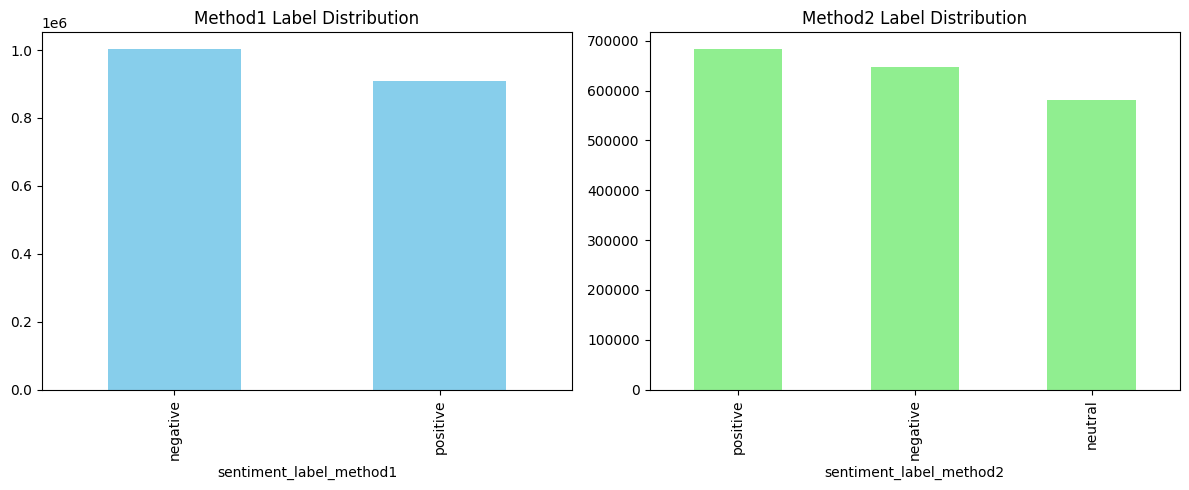

In [ ]:
# Plot class distribution for both methods
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

df_compare["sentiment_label_method1"].value_counts().plot(kind='bar', ax=ax[0], title='Method1 Label Distribution', color='skyblue')
df_compare["sentiment_label_method2"].value_counts().plot(kind='bar', ax=ax[1], title='Method2 Label Distribution', color='lightgreen')

plt.tight_layout()
plt.show()


## 2. Preprocessing
- lowercase

- remove special characters, emoji, urls, mentions

- tokenize

- remove stopwords

- stemming or lemmatization

- hashtag, slang, emoji

Read the annotation file.

In [ ]:
path = "/content/drive/MyDrive/NLP_Proj/Output/annotation_compare.csv"
df_compare = pd.read_csv(path)
pd.set_option('display.max_colwidth', None)
print(f"Shape of df_compare: {df_compare.shape}")
display(df_compare.head()) # print the first 5 rows of the dataset

Shape of df_compare: (1581466, 3)


,text,sentiment_label_method1,sentiment_label_method2
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",negative,negative
1,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,negative,negative
2,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,negative,neutral
3,my whole body feels itchy and like its on fire,negative,negative
4,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",negative,negative


Define related data structures.

In [ ]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Define a basic slang dictionary
slang_dict = {
    "u": "you", "r": "are", "idk": "i do not know", "btw": "by the way",
    "lol": "laugh out loud", "omg": "oh my god", "ttyl": "talk to you later",
    "smh": "shaking my head", "brb": "be right back"
}

# Define emoji to label mapping
emoji_map = {
    "😀": "emoji_happy", "😃": "emoji_happy", "😂": "emoji_laugh",
    "😢": "emoji_cry", "😭": "emoji_cry", "❤️": "emoji_love",
    "💔": "emoji_sad", "😡": "emoji_angry", "👍": "emoji_thumbsup"
}

# Main preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Replace emojis with label tokens
    text = "".join(emoji_map.get(char, char) for char in text)

    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # Remove user mentions, keep hashtags without symbol
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)

    # Remove non-alphabetic characters (keep spaces)
    text = re.sub(r"[^a-z\s]", " ", text)

    # Tokenize text
    tokens = word_tokenize(text)

    # Replace slang terms with full forms
    tokens = [slang_dict.get(word, word) for word in tokens]

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back to a single string
    return " ".join(tokens)

Create a new annotation copy - df_clean

In [ ]:
# Create a copy to avoid modifying original df
df_clean = df_compare[["text", "sentiment_label_method2"]].copy()
df_clean["text_cleaned"] = df_clean["text"].apply(preprocess_text)
print(f"Shape of df_clean: {df_clean.shape}")
df_clean.head()
df_clean.to_csv("/content/drive/MyDrive/NLP_Proj/Output/method2_cleaned.csv", index=False)

Drop nan from cleaned dataframe. (Only Run once)

In [ ]:
df_clean = df_clean.dropna(subset=["text_cleaned"])
print(f"Shape of df_clean: {df_clean.shape}")
df_clean.to_csv("/content/drive/MyDrive/NLP_Proj/Output/_method2_cleaned.csv")
df_clean.head()

Shape of df_clean: (1573176, 3)


,text,sentiment_label_method2,text_cleaned
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative,bummer shoulda got david carr third day
1,is upset that he can't update his Facebook by ...,negative,upset update facebook texting might cry result...
2,@Kenichan I dived many times for the ball. Man...,neutral,dived many time ball managed save rest go bound
3,my whole body feels itchy and like its on fire,negative,whole body feel itchy like fire
4,"@nationwideclass no, it's not behaving at all....",negative,behaving mad see


## 3. Feature Extraction and Model Comparison

### Feature Extraction methods
- Experiment 1: Bag of Words + Naive Bayes
- Experiment 2: TF-IDF + logistic regression
- Experiment 3: BERT Sentence Embedding + 'MLP / LogisticRegression'

Load preprocessed data - df_clean

In [ ]:
path = "/content/drive/MyDrive/NLP_Proj/Output/_method2_cleaned.csv"
df_clean = pd.read_csv(path)

print(f"Shape of df_clean: {df_clean.shape}")
df_clean.head()

Shape of df_clean: (1573176, 4)


,Unnamed: 0,text,sentiment_label_method2,text_cleaned
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative,bummer shoulda got david carr third day
1,1,is upset that he can't update his Facebook by ...,negative,upset update facebook texting might cry result...
2,2,@Kenichan I dived many times for the ball. Man...,neutral,dived many time ball managed save rest go bound
3,3,my whole body feels itchy and like its on fire,negative,whole body feel itchy like fire
4,4,"@nationwideclass no, it's not behaving at all....",negative,behaving mad see


### Experiment 1: Bag of Words + Naive Bayes

Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.71      0.72     99985
     neutral       0.60      0.57      0.58     95079
    positive       0.74      0.77      0.76    119572

    accuracy                           0.69    314636
   macro avg       0.69      0.69      0.69    314636
weighted avg       0.69      0.69      0.69    314636



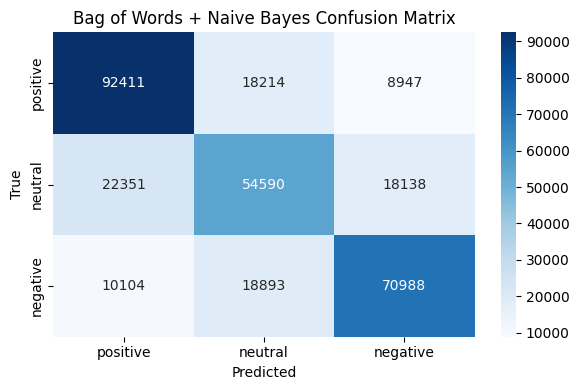

In [ ]:
# Select features for independent and dependent variables
X = df_clean["text_cleaned"]
y = df_clean["sentiment_label_method2"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Conduct Bag of Words vectorization
vectorizer = CountVectorizer(max_features=5000)
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Perform Naive Bayes training
nb_model = MultinomialNB()
nb_model.fit(X_train_bow, y_train)

# Predict on testing set
y_pred = nb_model.predict(X_test_bow)

# Print Evaluation report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred, labels=["positive", "neutral", "negative"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["positive", "neutral", "negative"],
            yticklabels=["positive", "neutral", "negative"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Bag of Words + Naive Bayes Confusion Matrix")
plt.tight_layout()
plt.show()


Store bow vectors into x_train_bow.npz and X_test_bow.npz.

In [ ]:
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

path = "/content/drive/MyDrive/NLP_Proj/Output/_method2_cleaned.csv"
folder = "/content/drive/MyDrive/NLP_Proj/Output/features/bow"
os.makedirs(folder, exist_ok=True)
joblib.dump(vectorizer, f"{folder}/bow_vectorizer.pkl")


# Save to sparse npz
sparse.save_npz(f"{folder}/x_train_bow.npz", X_train_bow)
sparse.save_npz(f"{folder}/x_test_bow.npz", X_test_bow)

# Load from sparse npz
X_train_bow = sparse.load_npz(f"{folder}/x_train_bow.npz")
X_test_bow = sparse.load_npz(f"{folder}/x_test_bow.npz")


### Experiment 2: TF-IDF + logistic regression

Classification Report:
              precision    recall  f1-score   support

    negative       0.77      0.72      0.74     99985
     neutral       0.64      0.72      0.68     95079
    positive       0.82      0.78      0.80    119572

    accuracy                           0.74    314636
   macro avg       0.74      0.74      0.74    314636
weighted avg       0.75      0.74      0.75    314636



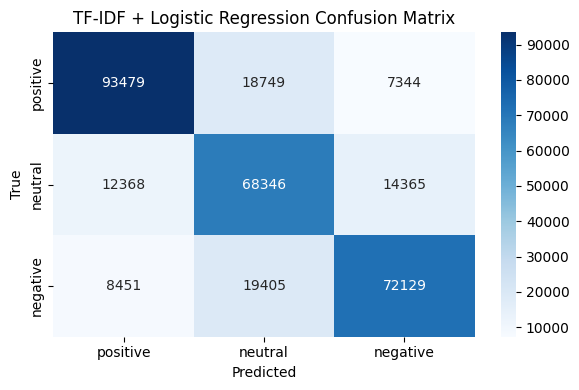

In [ ]:
# Prepare features and labels
X = df_clean["text_cleaned"]
y = df_clean["sentiment_label_method2"]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Perform TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)  # You can adjust this
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train Logistic Regression model
clf = LogisticRegression(max_iter=200)
clf.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_tfidf)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix plot
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred, labels=["positive", "neutral", "negative"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["positive", "neutral", "negative"], yticklabels=["positive", "neutral", "negative"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("TF-IDF + Logistic Regression Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
path = "/content/drive/MyDrive/NLP_Proj/Output/_method2_cleaned.csv"
folder = "/content/drive/MyDrive/NLP_Proj/Output/features/tfidf"
os.makedirs(folder, exist_ok=True)
joblib.dump(tfidf, f"{folder}/tfidf_vectorizer.pkl")

# Save to sparse npz
sparse.save_npz(f"{folder}/x_train_tfidf.npz", X_train_tfidf)
sparse.save_npz(f"{folder}/x_test_tfidf.npz", X_test_tfidf)

# Load from sparse npz
X_train_tfidf = sparse.load_npz(f"{folder}/x_train_tfidf.npz")
X_test_tfidf = sparse.load_npz(f"{folder}/x_test_tfidf.npz")


### Experiment 3-1: BERT Sentence Embedding + LogisticRegression

Generate embedding vectors by Bert.

In [ ]:
# Select input and output features
X = df_clean["text_cleaned"].tolist()
y = df_clean["sentiment_label_method2"]

# Train teset Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Load pre-trained BERT model and embed
model = SentenceTransformer("all-MiniLM-L6-v2")  # 384-dim, fast and good
X_train_emb = model.encode(X_train, batch_size=64, show_progress_bar=True)
X_test_emb = model.encode(X_test, batch_size=64, show_progress_bar=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/19665 [00:00<?, ?it/s]

Batches:   0%|          | 0/4917 [00:00<?, ?it/s]

Save the embedding vectors.

In [ ]:
path = "/content/drive/MyDrive/NLP_Proj/Output/_method2_cleaned.csv"
folder = "/content/drive/MyDrive/NLP_Proj/Output/features/bert"
os.makedirs(folder, exist_ok=True)

X_train_sparse = sparse.csr_matrix(X_train_emb)
X_test_sparse = sparse.csr_matrix(X_test_emb)
sparse.save_npz(f"{folder}/X_train_bert.npz", X_train_sparse)
sparse.save_npz(f"{folder}/X_test_bert.npz", X_test_sparse)

X_train_emb = sparse.load_npz(f"{folder}/X_train_bert.npz").toarray()
X_test_emb = sparse.load_npz(f"{folder}/X_test_bert.npz").toarray()


Classification using LogisticRegression

Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.71      0.71     99985
     neutral       0.62      0.61      0.62     95079
    positive       0.76      0.76      0.76    119572

    accuracy                           0.70    314636
   macro avg       0.70      0.70      0.70    314636
weighted avg       0.70      0.70      0.70    314636



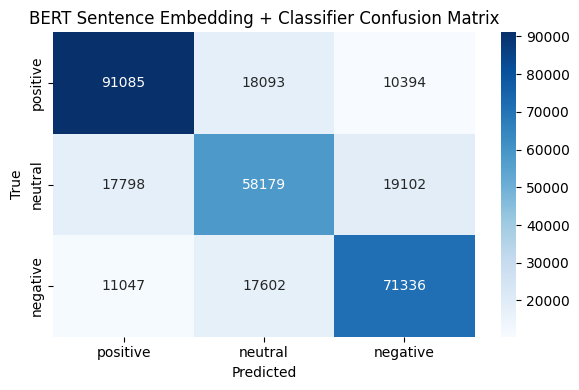

In [ ]:
# Choose classifier
clf = LogisticRegression(max_iter=200)
# clf = MLPClassifier(hidden_layer_sizes=(256,), max_iter=10, random_state=42)

# Train and predict
clf.fit(X_train_emb, y_train)
y_pred = clf.predict(X_test_emb)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred, labels=["positive", "neutral", "negative"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["positive", "neutral", "negative"],
            yticklabels=["positive", "neutral", "negative"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("BERT Sentence Embedding + Classifier Confusion Matrix")
plt.tight_layout()
plt.show()


### Experiment 3-2: BERT Sentence Embedding + MLP

Classification using MLP

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.74      0.75     99985
     neutral       0.66      0.66      0.66     95079
    positive       0.79      0.79      0.79    119572

    accuracy                           0.74    314636
   macro avg       0.73      0.73      0.73    314636
weighted avg       0.74      0.74      0.74    314636



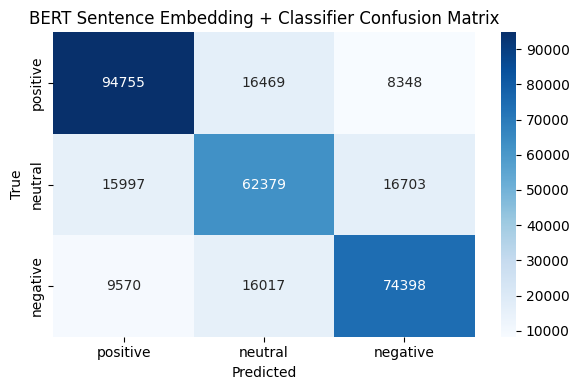

In [ ]:
# Choose classifier
clf = MLPClassifier(hidden_layer_sizes=(256,), max_iter=10, random_state=42)  # optional

# Train and predict
clf.fit(X_train_emb, y_train)
y_pred = clf.predict(X_test_emb)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred, labels=["positive", "neutral", "negative"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["positive", "neutral", "negative"],
            yticklabels=["positive", "neutral", "negative"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("BERT Sentence Embedding + Classifier Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
# Re-import necessary library due to state reset
import pandas as pd

# Create a comparison DataFrame for all 4 experimental results
comparison_data = {
    "Model": [
        "Bag of Words + Naive Bayes",
        "TF-IDF + Logistic Regression",
        "BERT + Logistic Regression",
        "BERT + MLP"
    ],
    "Negative Precision": [0.72, 0.77, 0.71, 0.75],
    "Neutral Precision": [0.60, 0.64, 0.62, 0.66],
    "Positive Precision": [0.74, 0.82, 0.76, 0.79],
    "Accuracy": [0.69, 0.74, 0.70, 0.74],
    "Weighted F1-score": [0.69, 0.75, 0.70, 0.74]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)


,Model,Negative Precision,Neutral Precision,Positive Precision,Accuracy,Weighted F1-score
0,Bag of Words + Naive Bayes,0.72,0.60,0.74,0.69,0.69
1,TF-IDF + Logistic Regression,0.77,0.64,0.82,0.74,0.75
2,BERT + Logistic Regression,0.71,0.62,0.76,0.70,0.70
3,BERT + MLP,0.75,0.66,0.79,0.74,0.74


## Conclusion:
The TF-IDF + Logistic Regression model stands out as the best trade-off between simplicity and performance, while BERT-based models offer competitive results, especially for Positive sentiment detection. Naive Bayes, though simple, lags behind in all metrics.

## Future work
Maybe we can try using TF-IDF + MLP, to see if we can get a better results.